In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv(r'https://raw.githubusercontent.com/SumanGouda/Scikit-Learn-/refs/heads/main/PROJECT/CAR%20PRICE%20PREDICTION/Car_dataset.csv')
df.shape

(19237, 16)

In [74]:
numerical_cols = ['Price', 'Levy', 'year', 'Engine_volume_value', 'Mileage', 'Cylinders', 'Airbags']
categorical_cols = ['Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Gear type', 'Wheel', 'Color']

In [10]:
def classify_columns(df):
    numerical_cols = []
    categorical_cols = []
    
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            numerical_cols.append(col)
        elif pd.api.types.is_object_dtype(df[col]):
            categorical_cols.append(col)
    
    return numerical_cols, categorical_cols

# classify columns in the dataframe on the basis of data types : 
numerical_cols, categorical_cols = classify_columns(df)
print(numerical_cols)
print(categorical_cols)

['ID', 'Price', 'Levy', 'year', 'Cylinders', 'Airbags']
['Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Engine volume', 'Mileage', 'Gear type', 'Wheel', 'Color']


### Data Cleaning 

In [7]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots: 1 row, as many columns as categorical_cols
fig = make_subplots(rows=1, cols=len(categorical_cols),
                    subplot_titles=[f'{col}' for col in categorical_cols])

# Loop through categorical columns and add a subplot for each
for i, col in enumerate(categorical_cols):
    fig.add_trace(
        go.Bar(
            x=df[col].value_counts().index,
            y=df[col].value_counts().values
        ),
        row=1,
        col=i+1
    )

# Update layout
fig.update_layout(
    title='Distribution of Categorical Columns',
    template='plotly_dark',
    showlegend=False,
    width=400 * len(categorical_cols),   # 400px width per subplot
    height=500
)

fig.show()


In [9]:
# Cleanign the leavy column & change the data type to int
df['Levy'] = df['Levy'].replace('-', np.nan)
df['Levy'] = df['Levy'].astype(float)

In [11]:
# Cleaning the 'Mileage' column by removing 'km' and converting to integer
df['Mileage'] = df['Mileage'].str.replace('km', '').str.replace(',', '').astype(int)

In [ ]:
# Cleanig the 'Engine_volume' column by removing 'Turbo' and converting to integer
df['Engine_volume_value'] = df['Engine volume'].str.replace('Turbo', '').astype(float)
df['Enigine_type'] = df['Engine volume'].apply(lambda x: 'Turbo' if 'Turbo' in x else 'Non-Turbo')
df.drop('Engine volume', axis=1, inplace=True)

In [76]:
def remove_units(col):
    return str(col).split(' ')[0]  # Convert to string before splitting

def make_zero_nan(col):
    try:
        # First attempt to convert to integer
        int_val = int(col)
        # Return np.nan if zero, otherwise return the integer
        return np.nan if int_val == 0 else int_val
    except (ValueError, TypeError):
        # Return original value if conversion fails
        return col

def extract_types(col):
    if pd.isna(col):
        return (np.nan, np.nan)
    
    parts = str(col).split(' ')
    value = parts[0] if len(parts) > 0 else np.nan
    types = ' '.join(parts[1:]) if len(parts) > 1 else np.nan
    
    # Convert value to float if possible
    try:
        value = float(value)
    except (ValueError, TypeError):
        value = np.nan
        
    return (value, types)

def handle_hyphens(col):
    try:
        str_val = str(col).strip()  
        
        if str_val == '-':
            return np.nan
            
        return float(str_val)
    except (ValueError, TypeError):
        return np.nan  

In [77]:
# Cleaning The Mileage Column
df['Mileage'] = (
    df['Mileage']
    .apply(remove_units)
    .apply(make_zero_nan)
    .astype(float)
)

In [78]:
# Cleaning The Engine volume Column
df[['Engine_volume_value', 'Engine_volume_type']] = df['Engine volume'].apply(
    lambda x: pd.Series(extract_types(x))
)

df['Engine_volume_value'] = (
    df['Engine_volume_value']
    .apply(make_zero_nan)
    .astype(float)
)

df.drop('Engine volume', axis=1, inplace=True)

In [79]:
# Cleaning The Levy Column
df['Levy'] = df['Levy'].apply(handle_hyphens)

In [80]:
# Cleanign The Airbags Column as most of cars after 2000 installed airbags
df.loc[
    ((df['year'] > 2000) & (df['Airbags'] == 0)) |  # Condition 1: Any car post-2000 without airbags
    ((df['Manufacturer'] == 'MERCEDES-BENZ') & (df['year'] > 1991) & (df['Airbags'] == 0)),  # Condition 2: Mercedes post-1991 without airbags
    'Airbags'
] = np.nan

In [81]:
for cols in numerical_cols:
    print(f'Column name: {cols}\n{df[cols].describe()}', end='\n\n')

Column name: Price
count    1.923700e+04
mean     1.855593e+04
std      1.905813e+05
min      1.000000e+00
25%      5.331000e+03
50%      1.317200e+04
75%      2.207500e+04
max      2.630750e+07
Name: Price, dtype: float64

Column name: Levy
count    13418.000000
mean       906.838128
std        461.867051
min         87.000000
25%        640.000000
50%        781.000000
75%       1058.000000
max      11714.000000
Name: Levy, dtype: float64

Column name: year
count    19237.000000
mean      2010.912824
std          5.668673
min       1939.000000
25%       2009.000000
50%       2012.000000
75%       2015.000000
max       2020.000000
Name: year, dtype: float64

Column name: Engine_volume_value
count    19142.000000
mean         1.945617
std          0.910394
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         20.000000
Name: Engine_volume_value, dtype: float64

Column name: Mileage
count    1.851600e+04
mean     1.591900e+06
std      4.9336

### EDA 

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from warnings import filterwarnings
filterwarnings('ignore')

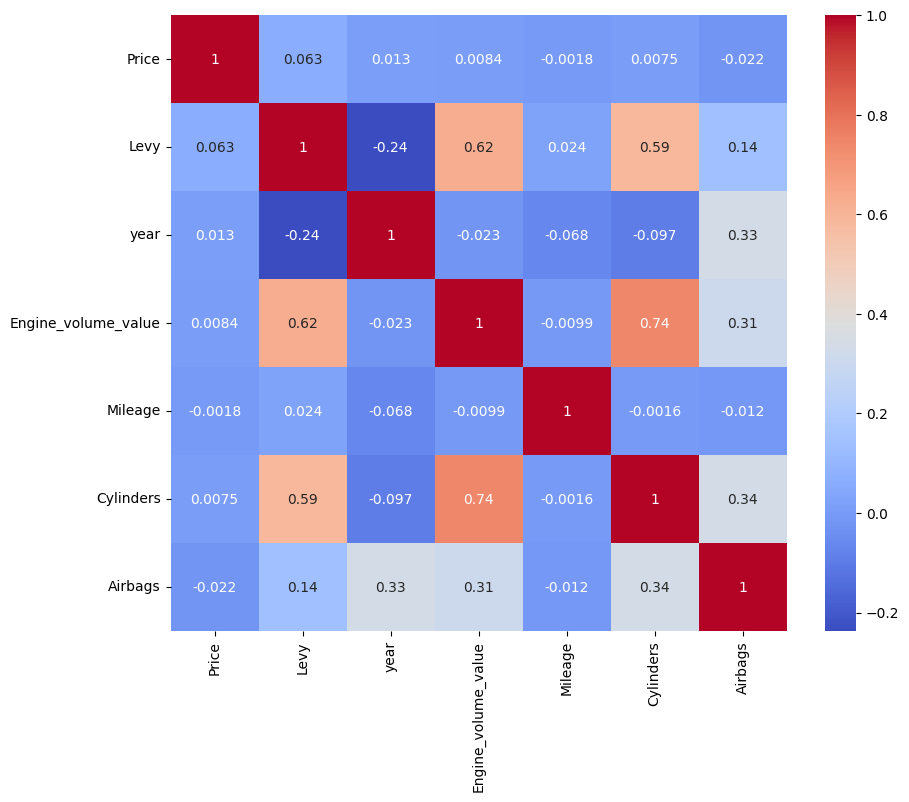

In [83]:
# calculate the correlation matrix
corr_matrix = df[numerical_cols].corr()

# create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)

# show the plot
plt.show()

##### Analysing the price column

In [84]:
df = df[(df['Price'] >= 2000) & (df['Price'] <= 500000)]

In [92]:
# Create subplots: 1 row, 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=("Box Plot", "PDF Plot"))

# Box plot
fig.add_trace(
    go.Box(
        x=df["Price"],
        boxpoints="outliers",  # Show outliers
        hoverinfo="text",
        hovertext=[f"Price: {price}" for price in df["Price"]]
    ),
    row=1, col=1
)

# Histogram (PDF-like plot)
fig.add_trace(
    go.Histogram(
        x=df["Price"],
        nbinsx=50
    ),
    row=1, col=2
)

# Update layout
fig.update_layout(
    title="Distribution of Price",
    template="plotly_dark"
)

fig.show()


In [87]:
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

outliers = (df['Price'] < (Q1 - 1.5 * IQR)) | (df['Price'] > (Q3 + 1.5 * IQR))
print(Q1, Q3, IQR)

9408.0 24920.0 15512.0
